In [29]:
import numpy as np
import keras
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
from utils import mix_with_noise
from os import listdir
from numpy.random import randint
import threading
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [19]:
import imp
imp.reload(mix_with_noise)

<module 'utils.mix_with_noise' from '/home/huckleberry/Projects/dsp/2/utils/mix_with_noise.py'>

In [2]:
def get_srate():
    return 22050

In [3]:
def fbank_features(audio):
    melgram = librosa.feature.melspectrogram
    
    N_FFT = 2048
    N_MELS = 96
    
    x = melgram(y=audio, sr=get_srate(), n_fft=N_FFT, n_mels=N_MELS)
    x = librosa.power_to_db(x, np.max)
    return x

In [4]:
def mfcc_features(fbank):
    return librosa.feature.mfcc(S=fbank)

In [5]:
def load_labels(path='../data/laugh/'):
    with open(path + 'labels.txt') as f:
        labels = f.read().split('\n')
        
    track_labels = {}
    file_names = []
    
    for label in labels[1:]:
        columns = label.split(',')
        file_name = columns[0]
        if file_name == '':
            continue
        
        file_names.append(file_name)
        
        for i in range(4, len(columns), 3):
            if columns[i] == 'laughter':
                if file_name not in track_labels:
                    track_labels[file_name] = []
                
                track_labels[file_name].append(
                    (float(columns[i + 1]), float(columns[i + 2])))
                
    return file_names, track_labels

file_names, track_labels = load_labels()

In [6]:
def preload_audio_files(file_names, path='../data/laugh/'):
    data = np.zeros((len(file_names), 242550))
    invert_index = {}
    
    for i, file in enumerate(file_names):
        audio = librosa.load(path + 'data/' + file + '.wav', sr=get_srate())[0]
        data[i, :audio.shape[0]] = audio
        invert_index[file] = i
        
    return data, invert_index

laugh_audio_files, laugh_index = preload_audio_files(file_names)

In [11]:
def audio_generator(file_names, laugh_audio, laugh_index, 
                    labels, path='../data/laugh/'):
    root = path + 'data/'
    while True:
        idx = randint(0, len(file_names))
        track_name = file_names[idx]
        audio = laugh_audio[laugh_index[track_name]]
        
        label = []
        if track_name in labels:
            label = labels[track_name]
        
        yield(audio, label)

audio_gen = audio_generator(file_names=file_names, 
                            laugh_audio=laugh_audio_files, 
                            laugh_index=laugh_index,
                            labels=track_labels)

In [20]:
noises = mix_with_noise.preload_noise_files([
    '../data/bg_noise/freesound_background_gsm/', 
    '../data/bg_noise/AUDIONAUTIX_MUSIC_gsm/',
    '../data/bg_noise/ASTERISK_MUSIC_gsm/'], get_srate())

In [21]:
def noise_generator(noises):
    while True:
        idx = randint(0, len(noises))
        yield noises[idx]
        
noise_gen = noise_generator(noises)

In [22]:
def get_features(audio):
    fbank = fbank_features(audio)
    mfcc = mfcc_features(fbank)
    return fbank, mfcc

def create_from_label(label):
    y = np.zeros((474,))
    
    for start, end in label:
        start_idx = int(start / 11. * 474.)
        end_idx = int(end / 11. * 474.)
        
        y[start_idx:end_idx] = 1.
    
    return y

class DataGenerator:
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        self.lock = threading.Lock()
        
    def __iter__(self):
        return self
    
    def __next__(self):
        batch_size = self.batch_size
        
        with self.lock:
            xs_f = np.zeros((batch_size, 96, 474))
            xs_m = np.zeros((batch_size, 20, 474))
            ys = np.zeros((batch_size, 474))

            for i in range(batch_size):
                track, label = next(audio_gen)
                noise = next(noise_gen)
                x = mix_with_noise.mix_with_noise(track, noise)
                x_fbank, x_mfcc = get_features(x)

                xs_f[i,:,:x_fbank.shape[1]] = x_fbank
                xs_m[i,:,:x_mfcc.shape[1]] = x_mfcc

                y = create_from_label(label)
                ys[i] = y

            xs_f = np.swapaxes(xs_f, 1, 2)
            xs_m = np.swapaxes(xs_m, 1, 2)
            return [xs_f, xs_m], [ys, ys]

In [23]:
def draw_fbank_spectrum(fbank, figw=12, figh=4):
    plt.figure(figsize=(figw,figh))
    librosa.display.specshow(fbank, sr=get_srate(), x_axis='time', y_axis='mel')
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

In [24]:
from keras.models import Input, Model
from keras.layers import LSTM, Dense, Merge, Reshape

def laugh_detector():
    fbank_input = Input(shape=(474, 96), 
                        dtype='float32', name='fbank_input')
    mfcc_input = Input(shape=(474, 20),
                      dtype='float32', name='mfcc_input')
    
    lstm_mfcc = LSTM(units=128, return_sequences=True)(mfcc_input)
    mfcc_out = Dense(units=1, activation='sigmoid', name='mfcc_out')(lstm_mfcc)
    mfcc_out = Reshape((474,))(mfcc_out)
    
    lstm_fbank = LSTM(units=128, return_sequences=True)(fbank_input)
    
    merged_features = keras.layers.concatenate(
        inputs=[lstm_mfcc, lstm_fbank], axis=2)
    output = Dense(units=1, activation='sigmoid', name='output')(merged_features)
    output = Reshape((474,))(output)
    
    model = Model(inputs=[fbank_input, mfcc_input],
                  outputs=[mfcc_out, output])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model
    
model = laugh_detector()

In [67]:
model.fit_generator(DataGenerator(), steps_per_epoch=10,
                        workers=4, epochs=300, shuffle=False)

Epoch 1/300
10/10 [==============================] - 31s 3s/step - loss: 0.3212 - reshape_1_loss: 0.1607 - reshape_2_loss: 0.1605 - reshape_1_acc: 0.9558 - reshape_2_acc: 0.9558
Epoch 2/300
10/10 [==============================] - 33s 3s/step - loss: 0.2627 - reshape_1_loss: 0.1312 - reshape_2_loss: 0.1314 - reshape_1_acc: 0.9659 - reshape_2_acc: 0.9659
Epoch 3/300
10/10 [==============================] - 32s 3s/step - loss: 0.2926 - reshape_1_loss: 0.1469 - reshape_2_loss: 0.1457 - reshape_1_acc: 0.9603 - reshape_2_acc: 0.9603
Epoch 4/300
10/10 [==============================] - 31s 3s/step - loss: 0.2889 - reshape_1_loss: 0.1447 - reshape_2_loss: 0.1442 - reshape_1_acc: 0.9621 - reshape_2_acc: 0.9621
Epoch 5/300
10/10 [==============================] - 34s 3s/step - loss: 0.2435 - reshape_1_loss: 0.1218 - reshape_2_loss: 0.1217 - reshape_1_acc: 0.9684 - reshape_2_acc: 0.9684
Epoch 6/300
10/10 [==============================] - 32s 3s/step - loss: 0.2451 - reshape_1_loss: 0.1228 - res

10/10 [==============================] - 32s 3s/step - loss: 0.2957 - reshape_1_loss: 0.1480 - reshape_2_loss: 0.1477 - reshape_1_acc: 0.9597 - reshape_2_acc: 0.9597
Epoch 47/300
10/10 [==============================] - 32s 3s/step - loss: 0.2869 - reshape_1_loss: 0.1431 - reshape_2_loss: 0.1438 - reshape_1_acc: 0.9583 - reshape_2_acc: 0.9583
Epoch 48/300
10/10 [==============================] - 31s 3s/step - loss: 0.2279 - reshape_1_loss: 0.1139 - reshape_2_loss: 0.1140 - reshape_1_acc: 0.9677 - reshape_2_acc: 0.9677
Epoch 49/300
10/10 [==============================] - 33s 3s/step - loss: 0.2811 - reshape_1_loss: 0.1410 - reshape_2_loss: 0.1401 - reshape_1_acc: 0.9617 - reshape_2_acc: 0.9617
Epoch 50/300
10/10 [==============================] - 32s 3s/step - loss: 0.2689 - reshape_1_loss: 0.1345 - reshape_2_loss: 0.1344 - reshape_1_acc: 0.9605 - reshape_2_acc: 0.9605
Epoch 51/300
10/10 [==============================] - 31s 3s/step - loss: 0.2571 - reshape_1_loss: 0.1286 - reshape_2_

10/10 [==============================] - 32s 3s/step - loss: 0.2008 - reshape_1_loss: 0.1001 - reshape_2_loss: 0.1007 - reshape_1_acc: 0.9722 - reshape_2_acc: 0.9726
Epoch 92/300
10/10 [==============================] - 32s 3s/step - loss: 0.2716 - reshape_1_loss: 0.1358 - reshape_2_loss: 0.1358 - reshape_1_acc: 0.9627 - reshape_2_acc: 0.9626
Epoch 93/300
10/10 [==============================] - 31s 3s/step - loss: 0.2388 - reshape_1_loss: 0.1189 - reshape_2_loss: 0.1198 - reshape_1_acc: 0.9634 - reshape_2_acc: 0.9634
Epoch 94/300
10/10 [==============================] - 31s 3s/step - loss: 0.2763 - reshape_1_loss: 0.1381 - reshape_2_loss: 0.1382 - reshape_1_acc: 0.9609 - reshape_2_acc: 0.9612
Epoch 95/300
10/10 [==============================] - 31s 3s/step - loss: 0.2575 - reshape_1_loss: 0.1288 - reshape_2_loss: 0.1286 - reshape_1_acc: 0.9634 - reshape_2_acc: 0.9639
Epoch 96/300
10/10 [==============================] - 32s 3s/step - loss: 0.2890 - reshape_1_loss: 0.1446 - reshape_2_

KeyboardInterrupt: 

In [68]:
def test(n=100):
    x_fs = np.zeros((n, 96, 474), dtype=np.float32)
    x_ms = np.zeros((n, 20, 474), dtype=np.float32)
    ys = np.zeros((n, 474), dtype=np.float32)
    
    for i in range(n):
        x, y = next(audio_gen)
        x_fbank, x_mfcc = get_features(x)
        
        x_fs[i] = x_fbank
        x_ms[i] = x_mfcc
        
        ys[i] = create_from_label(y)

    x_fs = np.swapaxes(x_fs, 1, 2)
    x_ms = np.swapaxes(x_ms, 1, 2)
    result = model.predict([x_fs, x_ms])

    ys = np.reshape(ys, (n * 474,))
    result_0 = np.reshape(result[0], (n * 474,))
    result_1 = np.reshape(result[1], (n * 474,))
    
    roc0 = roc_auc_score(ys, result_0)
    roc1 = roc_auc_score(ys, result_1)
    
    print('ROC AUC score on mfcc out', roc1)
    print('ROC AUC score on common out', roc0)
    
test()

ROC AUC score on mfcc out 0.830922937775
ROC AUC score on common out 0.830750320557


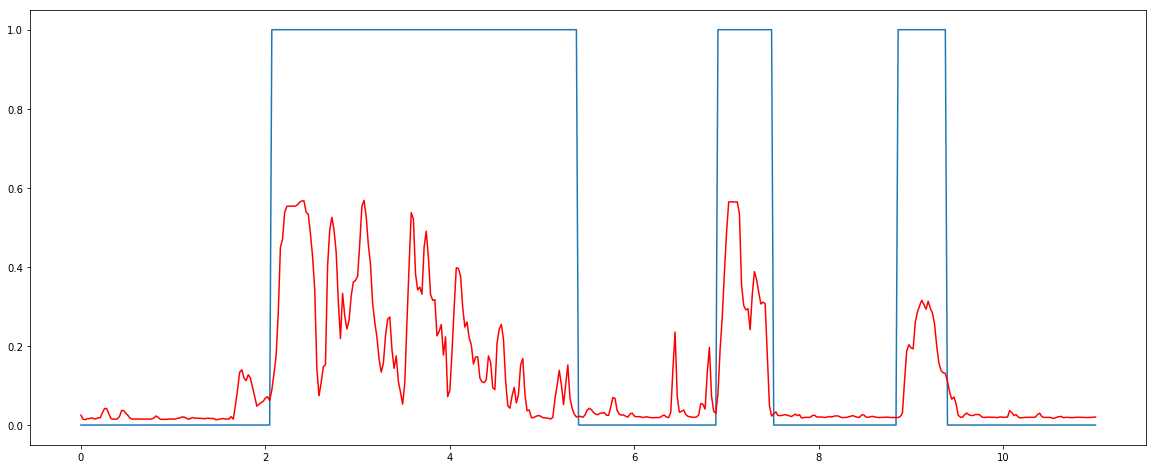

In [99]:
def draw_detections(figh=20, figw=8):
    x, y = next(audio_gen)
    x_fbank, x_mfcc = get_features(x)
    x_f = np.array([np.swapaxes(x_fbank, 0, 1)])
    x_m = np.array([np.swapaxes(x_mfcc, 0, 1)])
    
    y = create_from_label(y)
    result = model.predict([x_f, x_m])
    
    plt.figure(111, figsize=(figh, figw))
    
    x_axis = np.linspace(0, 11, 474)
    plt.plot(x_axis, y)
    plt.plot(x_axis, result[1][0], 'r')
    plt.show()
    
draw_detections()